In [17]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance
from skimage import segmentation
from sklearn.decomposition import PCA



def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [27]:
#1
pizza = np.loadtxt('data/pizza.txt',skiprows=1)
pizza_pca = PCA(n_components=7)
pizza_pca.fit(pizza)
print(pizza_pca.explained_variance_ratio_.cumsum())

[0.78010108 0.96850768 0.99964088 0.99998214 0.99999763 0.99999955
 1.        ]


In [33]:
#2
newshit = 3 * pizza_pca.components_[0]
newslice = np.mean(pizza, axis=0) + newshit
print(newslice)

[40.07217639 12.57274229 19.39273266  2.46693105  0.63597518 25.49901976
  3.26919014]


[104.5        107.5        110.         ... 178.16666667 180.33333333
 178.66666667]


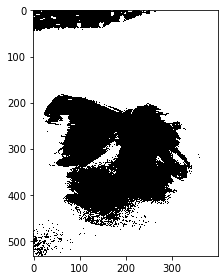

In [45]:
#3
from skimage.util import img_as_ubyte
def create_u_byte_image_from_vector(im_vec, height, width):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width)
    im_out = img_as_ubyte(im_vec)
    return im_out

import glob
import os
files = glob.glob("data/orchid*.png")
height, width = io.imread(files[0]).shape
data_matrix = np.zeros((len(files), height * width))
for i, f in enumerate(files):
    data_matrix[i, :] = io.imread(f).flatten()
meancat = np.mean(data_matrix, axis=0)
print(meancat)
meanimg = create_u_byte_image_from_vector(meancat,height,width)
newmean = meanimg > 150
io.imshow(newmean)

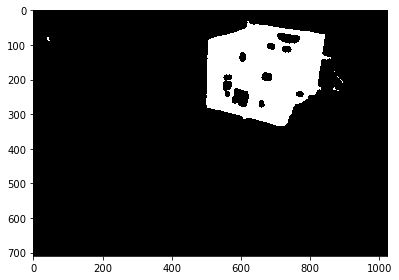

In [46]:
bike = io.imread('data/bikes.png')
r_comp = bike[:,:,0]
g_comp = bike[:,:,1]
b_comp = bike[:,:,2]
binarybikes = (r_comp < 100) & (g_comp > 200) & (b_comp > 100)
footprint = disk(8)
im_process = binary_closing(binarybikes, footprint)
img_c_b = segmentation.clear_border(im_process)
io.imshow(img_c_b)
io.show()

In [13]:
#

wall = io.imread('data/ClimbingWall.png')
r_comp = wall[:,:,0]
g_comp = wall[:,:,1]
b_comp = wall[:,:,2]
binarywall = (r_comp < 60) & (g_comp < 200) & (b_comp < 100)
show_comparison(wall, binarywall, 'wall vs binary')

footprint = disk(3)
im_process = binary_closing(binarywall, footprint)
img_c_b = segmentation.clear_border(im_process)
label_img = measure.label(img_c_b)
region_props = measure.regionprops(label_img)
n_nuclei = len(region_props)
print(n_nuclei)
min_area = 300
max_perim = 500
label_img_filter = label_img.copy()
for region in region_props:
    # Find the areas that do not fit our criteria
    if region.area < min_area or region.perimeter > max_perim:
        n_nuclei = n_nuclei - 1
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
print(n_nuclei)

566
20


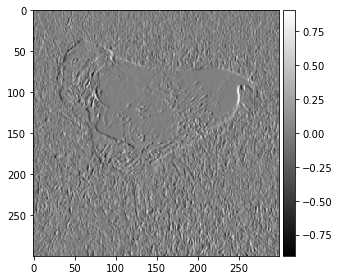

In [49]:
bird = io.imread('data/bird.png')
hsv_img = color.rgb2hsv(bird)
from skimage.filters import prewitt_v
#print(hsv_img.shape)
newtest = prewitt_v(hsv_img[:,:,1])
io.imshow(newtest,cmap='gray')
io.show()


In [70]:
from skimage.util import img_as_float
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 12/254
    max_desired = 230/254
	
    # Do something here
    img_out = ((img_float-min_val)*(max_desired-min_desired)/(max_val-min_val))+min_desired
    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_as_ubyte(img_out)

water = io.imread('data/water_gray.png')
from skimage.filters import median
def apply_median_filter(img,size):
    footprint = np.ones([size,size])
    med_img = median(img, footprint)
    return med_img
medianwater = apply_median_filter(water,3)
stretchwater = histogram_stretch(medianwater)
print(stretchwater[20,20])

217


In [76]:
in_dir = "data/"
ct = dicom.read_file(in_dir + '1-131.dcm')
img = ct.pixel_array
def load_mask(mask_path):
    roi = io.imread(mask_path)
    mask = roi > 0
    return mask
def get_values(img, mask_path):
    mask = load_mask(mask_path)
    return img[mask]

paths = ['BoneROI.png','LiverROI.png','SpleenROI.png']
values = [get_values(img, in_dir + path) for path in paths]
spleen_mean = np.mean(values[2])
bone_mean = np.mean(values[0])
liver_mean = np.mean(values[1])

print(f'Spleen tissue mean: {spleen_mean}, bone mean: {bone_mean}, liver_mean: {liver_mean}')

t_spleen_liver = (spleen_mean + liver_mean)/2
t_spleen_bone = (spleen_mean + bone_mean)/2
t_background = -200
liver_img = (img > t_background) & (img <= t_spleen_liver)
spleen_img = (img > t_spleen_liver) & (img < t_spleen_bone)
bone_img = (img > t_spleen_bone) & (img < 1000)
print(t_spleen_liver,t_spleen_bone)

Spleen tissue mean: 124.72452830188679, bone mean: 838.4418604651163, liver_mean: 73.28221208665906
99.00337019427292 481.58319438350156


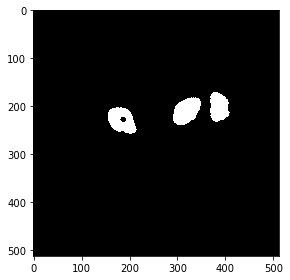

In [77]:
def spleen_finder(img):
    t_1, t_2 = 85, 400
    spleen_estimate = (img > t_1) & (img < t_2)
    footprint = disk(5)
    closed = binary_closing(spleen_estimate, footprint)
    footprint = disk(3)
    opened = binary_opening(closed, footprint)
    label_img = measure.label(opened)
    region_props = measure.regionprops(label_img)
    min_area = 1000
    max_area = 4000
    label_img_filter = label_img.copy()
    for region in region_props:
        crit1 = region.area > max_area or region.area < min_area
        #crit2 = region.perimeter > max_perim or region.perimeter < min_perim
        if crit1:# or crit2:
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
    i_area = label_img_filter > 0
    return i_area
areaimg = spleen_finder(img)
io.imshow(areaimg)
io.show()

In [95]:
import scipy.io as sio
import math
dst = sio.loadmat('data/donaldfixedPoints.mat')
src = sio.loadmat('data/donaldmovingPoints.mat')
dst = dst['fixedPoints']
src = src['movingPoints']
d1 = io.imread('data/donald_1.png')
d2 = io.imread('data/donald_2.png')

srcmean = np.mean(src)
dstmean = np.mean(dst)
ex = dstmean-srcmean
print(math.sqrt(ex*ex))

4.287245444801698


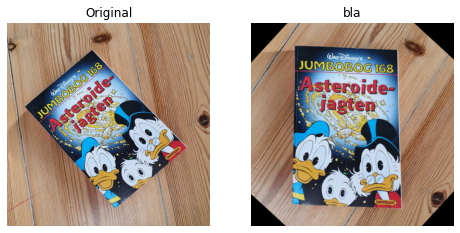

[17 21 32]


In [109]:
from skimage.transform import EuclideanTransform
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.transform import matrix_transform

tform = SimilarityTransform()
tform.estimate(src, dst)
src_img = d2
warped = warp(src_img, tform.inverse)
show_comparison(src_img,warped,'bla')
print(img_as_ubyte(warped)[299,299])

In [111]:
cw = 0.0054
ch = 0.0042
cwp = cw * (6480/5.4) * (5040/5.4)
cwp = ch * (6480/5.4) * (5040/5.4)
pw = cw/cwp
f = 0.0015
b = f
G = 1.5
G_aux = g*B/b # Real world distance corresponding to 240 pixels
print(pw*2400)


0.0027551020408163266


In [115]:
def dice_score(img,gt):
    dice_score = 1 - distance.dice(img.ravel(), gt.ravel())
    return dice_score
boxroi = io.imread('data/boxROI.png')
r_comp = bike[:,:,0]
g_comp = bike[:,:,1]
b_comp = bike[:,:,2]
binbike = (r_comp < 100) & (g_comp > 200) & (b_comp > 100)
footprint = disk(8)
im_process = binary_closing(binbike, footprint)
print(dice_score(boxroi,im_process))

1.754631822669904
